In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import r2_score as r2

pd.options.display.max_columns = 100

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
data = pd.read_csv('input/train.csv')

In [4]:
s = (data['Floor'] > data['HouseFloor']) | (data['HouseFloor'] > 40)
data.loc[s, ['Floor','HouseFloor']] = math.floor(data['Floor'].median()), math.floor(data['HouseFloor'].median())

In [5]:
data.shape

(10000, 20)

In [6]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
data.loc[data['Rooms'] > 5, :]
data.loc[data['Id'].isin([5927, 14003, 14865]), 'Rooms'] = 2
data.loc[data['Id'] == 8491, 'Rooms'] = 1

data.loc[data['HouseYear'] == 20052011, 'HouseYear'] = 2008
data.loc[data['HouseYear'] == 4968, 'HouseYear'] = 1968

small_square_ids = data.loc[data['Square'] < 15, 'Id'].values
mean_square = data.groupby('Rooms', as_index=False)[['Square']].mean().rename(columns={'Square': 'mean_square'})
data = pd.merge(data, mean_square, on='Rooms', how='left')
data.loc[data['Id'].isin(small_square_ids), 'Square'] = data['mean_square']
data.loc[data['Id'].isin(small_square_ids), 'LifeSquare'] = data['Square']

large_square_ids = data.loc[data['Square'] > 150, 'Id'].values
data.loc[data['Id'].isin(large_square_ids), 'Square'] = data['mean_square']
data.loc[data['Id'].isin(large_square_ids), 'LifeSquare'] = data['Square']

data['LifeSquare'] = data['LifeSquare'].fillna(data['Square'])

data = data.drop(columns='mean_square')

### train_test_split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train, valid = train_test_split(data, test_size=0.3, random_state=45)

In [10]:
train.shape, valid.shape

((7000, 20), (3000, 20))

### Prepare train, valid

In [11]:
def add_info1(df, df_source, feat):
    flat_qty = 'flat_qty_'+feat
    distr_info1 = df_source[feat].value_counts(normalize=True).reset_index().\
        rename(columns={'index':feat, feat:flat_qty})
    
    df = pd.merge(df, distr_info1, on=feat, how='left')
    df[flat_qty] = df[flat_qty].fillna(df[flat_qty].min())
    return df

In [12]:
def add_mean(df, df_source, feat):
    m_feat = 'mean_' + feat
    
    distr_stat_dr = df_source.groupby([feat, 'Rooms'], as_index=False)[['Price']].mean().\
        rename(columns={'Price':m_feat})
    distr_stat_r = df_source.groupby(['Rooms'], as_index=False)[['Price']].mean().rename(columns={'Price':'mean_r'})
    m_price = df_source['Price'].median()
    
    df = pd.merge(df, distr_stat_dr, on=[feat, 'Rooms'], how='left')
    df = pd.merge(df, distr_stat_r, on='Rooms', how='left')
    
    df['mean_r'] = df['mean_r'].fillna(m_price)
    df[m_feat] = df[m_feat].fillna(df['mean_r'])
    df = df.drop(columns='mean_r')
    return df

In [13]:
def add_median(df, df_source, feat):
    m_feat = 'mdn_' + feat
    
    distr_stat_dr = df_source.groupby([feat, 'Rooms'], as_index=False)[['Price']].median().\
        rename(columns={'Price':m_feat})
    distr_stat_r = df_source.groupby(['Rooms'], as_index=False)[['Price']].median().rename(columns={'Price':'mdn_r'})
    m_price = df_source['Price'].median()
    
    df = pd.merge(df, distr_stat_dr, on=[feat, 'Rooms'], how='left')
    df = pd.merge(df, distr_stat_r, on='Rooms', how='left')
    
    df['mdn_r'] = df['mdn_r'].fillna(m_price)
    df[m_feat] = df[m_feat].fillna(df['mdn_r'])
    df = df.drop(columns='mdn_r')
    return df

In [14]:
def add_cat_fts(df, cat_fts=('Ecology_2', 'Ecology_3', 'Shops_2')):
    for col in cat_fts:
        df[col] = (df[col] == 'B').astype(int)
    return df

In [15]:
def fillna_healthcare_1(df):
    df['Healthcare_1'] = df['Healthcare_1'].fillna(0)
    return df

In [16]:
def prepare_data(df, df_source):
    df = add_info1(df, df_source, 'DistrictId')
    df = add_info1(df, df_source, 'HouseFloor')
    df = add_info1(df, df_source, 'HouseYear')
    df = add_info1(df, df_source, 'Social_3')
    df = add_info1(df, df_source, 'Helthcare_2')
    df = add_info1(df, df_source, 'Shops_1')
    
    df = add_mean(df, df_source, 'DistrictId')
    df = add_mean(df, df_source, 'HouseFloor')
    df = add_mean(df, df_source, 'HouseYear')
    df = add_mean(df, df_source, 'Social_3')
    df = add_mean(df, df_source, 'Helthcare_2')
    df = add_mean(df, df_source, 'Shops_1')
    
    df = add_median(df, df_source, 'DistrictId')
    df = add_median(df, df_source, 'HouseFloor')
    df = add_median(df, df_source, 'HouseYear')
    df = add_median(df, df_source, 'Social_3')
    df = add_median(df, df_source, 'Helthcare_2')
    df = add_median(df, df_source, 'Shops_1')
    
    df = add_cat_fts(df)
    df = fillna_healthcare_1(df)
    
    return df

In [17]:
train = prepare_data(train, train)

In [18]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,flat_qty_DistrictId,flat_qty_HouseFloor,flat_qty_HouseYear,flat_qty_Social_3,flat_qty_Helthcare_2,flat_qty_Shops_1,mean_DistrictId,mean_HouseFloor,mean_HouseYear,mean_Social_3,mean_Helthcare_2,mean_Shops_1,mdn_DistrictId,mdn_HouseFloor,mdn_HouseYear,mdn_Social_3,mdn_Helthcare_2,mdn_Shops_1
0,7293,10,2.0,47.622922,28.454948,6.0,6,9.0,1976,0.282798,1,1,33,8667,2,0.0,0,6,1,189796.279549,0.005429,0.121857,0.017571,0.064000,0.424429,0.048714,231458.796780,203900.564140,225475.689614,228150.854219,188162.854008,241354.891448,217009.909079,201921.439935,204279.404547,222990.817297,183649.790714,217148.777114
1,3621,22,2.0,58.853794,58.853794,1.0,10,17.0,1977,0.118537,1,1,30,6207,1,1183.0,1,0,1,175229.645872,0.007571,0.217286,0.265429,0.183000,0.217000,0.230143,200941.463080,207106.188269,188847.219360,190359.962009,234648.697365,175399.340231,189344.589863,189629.517951,182673.991330,186983.021586,229545.935360,177688.291841
2,6171,91,1.0,39.849560,19.192526,9.0,14,16.0,1991,0.333892,1,1,30,6564,1,0.0,0,0,1,115532.235899,0.005286,0.053000,0.007286,0.183000,0.424429,0.230143,160460.260074,175021.244184,165121.538844,149665.309066,139518.553339,131445.061593,155799.498372,179538.544973,165446.796345,146115.375726,134786.039301,129130.731628
3,9727,140,2.0,46.486141,25.792253,5.0,3,5.0,1963,0.000000,1,1,33,7425,1,0.0,2,5,1,241027.431895,0.001143,0.081429,0.015429,0.183000,0.112429,0.128571,262466.377094,195709.534542,211438.727651,190359.962009,216978.041809,221614.324749,241027.431895,189565.836672,190729.877647,186983.021586,199260.275978,203359.222652
4,16297,150,3.0,76.837424,46.482908,10.0,7,13.0,1978,0.300323,1,1,52,10311,6,0.0,1,9,1,381574.817711,0.001000,0.182143,0.012714,0.040429,0.217000,0.031000,321903.892042,284092.061686,270809.733332,330633.081330,308819.493480,299720.331794,342418.758888,247778.770893,266100.900431,325461.157704,307321.739944,289573.539750


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 38 columns):
Id                      7000 non-null int64
DistrictId              7000 non-null int64
Rooms                   7000 non-null float64
Square                  7000 non-null float64
LifeSquare              7000 non-null float64
KitchenSquare           7000 non-null float64
Floor                   7000 non-null int64
HouseFloor              7000 non-null float64
HouseYear               7000 non-null int64
Ecology_1               7000 non-null float64
Ecology_2               7000 non-null int32
Ecology_3               7000 non-null int32
Social_1                7000 non-null int64
Social_2                7000 non-null int64
Social_3                7000 non-null int64
Healthcare_1            7000 non-null float64
Helthcare_2             7000 non-null int64
Shops_1                 7000 non-null int64
Shops_2                 7000 non-null int32
Price                   7000 non-null float

In [20]:
valid = prepare_data(valid, train)

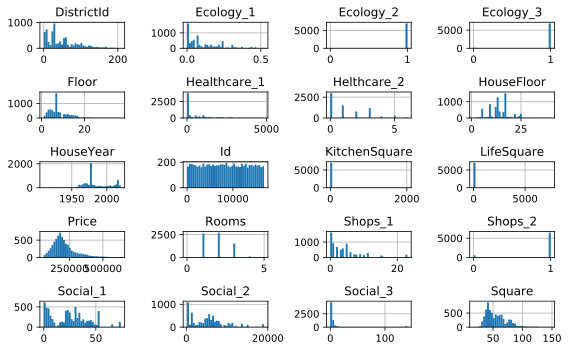

In [21]:
feats1 = list(filter(lambda s: s[0:9] != 'flat_qty_' and s[0:5] != 'mean_' and s[0:4] != 'mdn_', train.columns))
data1 = pd.DataFrame(train, columns=feats1)

data1.hist(bins=40, figsize=(8, 5), zorder=2)
plt.tight_layout()
plt.xlabel('', fontsize=4);

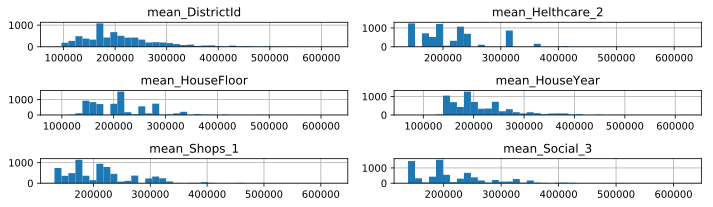

In [22]:
feats2 = list(filter(lambda s: s[0:5] == 'mean_', train.columns))
data2 = pd.DataFrame(train, columns=feats2)
data2.hist(bins=40, figsize=(10, 3), zorder=2)
plt.tight_layout()
plt.xlabel('', fontsize=4);

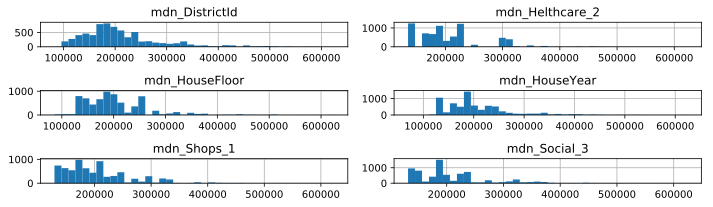

In [23]:
feats3 = list(filter(lambda s: s[0:4] == 'mdn_', train.columns))
data3 = pd.DataFrame(train, columns=feats3)
data3.hist(bins=40, figsize=(10, 3), zorder=2)
plt.tight_layout()
plt.xlabel('', fontsize=4);

In [24]:
# min_year = np.int(data['HouseYear'].min())
# max_year = np.int(data['HouseYear'].max())
# display((min_year, max_year))

# for year in np.sort(data['HouseYear'].unique()):
#     if year < 1964:
#         continue
#     data_year = data[data['HouseYear'] == year]
#     data_year_2 = data[(data['HouseYear'] == year) & (data['Floor'] > data['HouseFloor'])]
#     plt.scatter(data_year[feat], data_year['Price'], zorder=2);
#     plt.scatter(data_year_2[feat], data_year_2['Price'], zorder=2);
    
#     min_hf = np.int(data[data['HouseYear'] == year][feat].min())
#     max_hf = np.int(data[data['HouseYear'] == year][feat].max() + 0.99)
    
#     plt.xticks(range(min_hf, max_hf))
#     plt.gca().xaxis.grid(True)
#     plt.gcf().set_size_inches(11, 3)
#     plt.title(year)
#     plt.show()

### Coef

In [25]:
feats = train.columns.drop(['Price', 'LifeSquare', 'Id', 'DistrictId', 'HouseFloor', 'HouseYear', 'Social_3', 'Helthcare_2', 'Shops_1']).values
feats

array(['Rooms', 'Square', 'KitchenSquare', 'Floor', 'Ecology_1',
       'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Healthcare_1',
       'Shops_2', 'flat_qty_DistrictId', 'flat_qty_HouseFloor',
       'flat_qty_HouseYear', 'flat_qty_Social_3', 'flat_qty_Helthcare_2',
       'flat_qty_Shops_1', 'mean_DistrictId', 'mean_HouseFloor',
       'mean_HouseYear', 'mean_Social_3', 'mean_Helthcare_2',
       'mean_Shops_1', 'mdn_DistrictId', 'mdn_HouseFloor',
       'mdn_HouseYear', 'mdn_Social_3', 'mdn_Helthcare_2', 'mdn_Shops_1'],
      dtype=object)

In [26]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import StandardScaler

In [27]:
lr = LR()
scaler = StandardScaler()

train_scaled = pd.DataFrame(train, columns=feats)
train_scaled = scaler.fit_transform(train_scaled)

lr.fit(train_scaled, train['Price'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

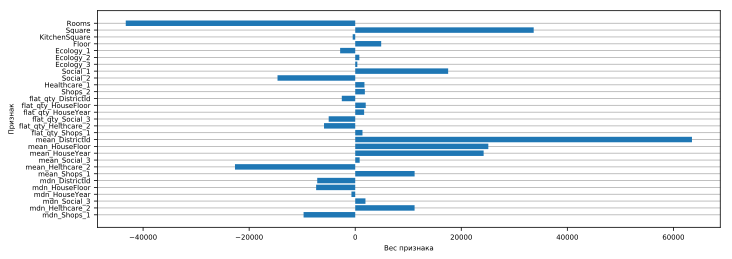

In [28]:
plt.rcParams.update({'font.size': 7})
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["axes.grid"] = True

plt.barh(feats, lr.coef_.flatten(), zorder=2)
plt.xlabel('Вес признака')
plt.ylabel('Признак')

fig = plt.gcf()
fig.set_size_inches(11.2, 4)
plt.gca().invert_yaxis()

### Model

In [29]:
train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'flat_qty_DistrictId',
       'flat_qty_HouseFloor', 'flat_qty_HouseYear', 'flat_qty_Social_3',
       'flat_qty_Helthcare_2', 'flat_qty_Shops_1', 'mean_DistrictId',
       'mean_HouseFloor', 'mean_HouseYear', 'mean_Social_3',
       'mean_Helthcare_2', 'mean_Shops_1', 'mdn_DistrictId', 'mdn_HouseFloor',
       'mdn_HouseYear', 'mdn_Social_3', 'mdn_Helthcare_2', 'mdn_Shops_1'],
      dtype='object')

In [30]:
# feats = ['Rooms', 'Square', 'flat_qty_DistrictId', 'mean_DistrictId', 'Helthcare_2', 'Healthcare_1', 'HouseYear']
#feats = ['Id', 'Square', 'Floor', 'HouseFloor', 'Ecology_3', 'Social_1', 'Social_2', 'Healthcare_1', 'Shops_1', 'Price']

In [31]:
from sklearn.ensemble import RandomForestRegressor as RF

In [32]:
# ?RF

In [33]:
model = RF(n_estimators=300, max_depth=12, random_state=42, max_features=4, min_samples_leaf=2)

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 38 columns):
Id                      7000 non-null int64
DistrictId              7000 non-null int64
Rooms                   7000 non-null float64
Square                  7000 non-null float64
LifeSquare              7000 non-null float64
KitchenSquare           7000 non-null float64
Floor                   7000 non-null int64
HouseFloor              7000 non-null float64
HouseYear               7000 non-null int64
Ecology_1               7000 non-null float64
Ecology_2               7000 non-null int32
Ecology_3               7000 non-null int32
Social_1                7000 non-null int64
Social_2                7000 non-null int64
Social_3                7000 non-null int64
Healthcare_1            7000 non-null float64
Helthcare_2             7000 non-null int64
Shops_1                 7000 non-null int64
Shops_2                 7000 non-null int32
Price                   7000 non-null float

In [35]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [36]:
pred_train = model.predict(train.loc[:, feats])

In [37]:
pred_train.shape

(7000,)

In [38]:
pred_train

array([202867.68464014, 191113.10369861, 160728.42778889, ...,
       192415.71593537, 182385.36082922, 117271.26067249])

In [39]:
pred_valid = model.predict(valid.loc[:, feats])

In [40]:
pred_valid.shape

(3000,)

In [41]:
pred_valid

array([241225.09512444, 113659.31322836, 347816.71779493, ...,
       204226.48950363, 259471.85103109, 221777.89624885])

In [42]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,flat_qty_DistrictId,flat_qty_HouseFloor,flat_qty_HouseYear,flat_qty_Social_3,flat_qty_Helthcare_2,flat_qty_Shops_1,mean_DistrictId,mean_HouseFloor,mean_HouseYear,mean_Social_3,mean_Helthcare_2,mean_Shops_1,mdn_DistrictId,mdn_HouseFloor,mdn_HouseYear,mdn_Social_3,mdn_Helthcare_2,mdn_Shops_1
0,7293,10,2.0,47.622922,28.454948,6.0,6,9.0,1976,0.282798,1,1,33,8667,2,0.0,0,6,1,189796.279549,0.005429,0.121857,0.017571,0.064000,0.424429,0.048714,231458.796780,203900.564140,225475.689614,228150.854219,188162.854008,241354.891448,217009.909079,201921.439935,204279.404547,222990.817297,183649.790714,217148.777114
1,3621,22,2.0,58.853794,58.853794,1.0,10,17.0,1977,0.118537,1,1,30,6207,1,1183.0,1,0,1,175229.645872,0.007571,0.217286,0.265429,0.183000,0.217000,0.230143,200941.463080,207106.188269,188847.219360,190359.962009,234648.697365,175399.340231,189344.589863,189629.517951,182673.991330,186983.021586,229545.935360,177688.291841
2,6171,91,1.0,39.849560,19.192526,9.0,14,16.0,1991,0.333892,1,1,30,6564,1,0.0,0,0,1,115532.235899,0.005286,0.053000,0.007286,0.183000,0.424429,0.230143,160460.260074,175021.244184,165121.538844,149665.309066,139518.553339,131445.061593,155799.498372,179538.544973,165446.796345,146115.375726,134786.039301,129130.731628
3,9727,140,2.0,46.486141,25.792253,5.0,3,5.0,1963,0.000000,1,1,33,7425,1,0.0,2,5,1,241027.431895,0.001143,0.081429,0.015429,0.183000,0.112429,0.128571,262466.377094,195709.534542,211438.727651,190359.962009,216978.041809,221614.324749,241027.431895,189565.836672,190729.877647,186983.021586,199260.275978,203359.222652
4,16297,150,3.0,76.837424,46.482908,10.0,7,13.0,1978,0.300323,1,1,52,10311,6,0.0,1,9,1,381574.817711,0.001000,0.182143,0.012714,0.040429,0.217000,0.031000,321903.892042,284092.061686,270809.733332,330633.081330,308819.493480,299720.331794,342418.758888,247778.770893,266100.900431,325461.157704,307321.739944,289573.539750


### Genetic

In [43]:
from itertools import compress

def filt(feat_genes):
    return list(compress(feats, feat_genes))

In [44]:
import random
#from concurrent.futures import ProcessPoolExecutor

class Chromosome:
    def __init__(self, generate=False):
        if generate:
            self._generate()
        self.fitness = 0
        self.done = False
        self.just_done = False
        self.mutated = False
        
    @property
    def feats_genes(self):
        return self.genes[:len(feats)]

    @property
    def other_genes(self):
        return self.genes[len(feats):]

    def _generate(self):
        self.genes = [random.choice([True, False]) for _ in range(len(feats))]

        n_estimators = 100
        max_depth = random.randint(8, 18)
        min_samples_split = random.randint(1, 10)
        min_samples_leaf = random.randint(1, 10)
        min_weight_fraction_leaf = random.uniform(0, 5)
        max_features = random.choice([None, 'sqrt', 'log2', random.randint(3, len(feats))])
        max_leaf_nodes = random.randint(1, 100)
        min_impurity_decrease = random.uniform(0, 5)
        
        self.genes.append(n_estimators)
        self.genes.append(max_depth)
        self.genes.append(min_samples_split)
        self.genes.append(min_samples_leaf)
        self.genes.append(min_weight_fraction_leaf)
        self.genes.append(max_features)
        self.genes.append(max_leaf_nodes)
        self.genes.append(min_impurity_decrease)

    def set_fitness(self):
        if self.done:
            self.just_done = False
        else:
            feats_genes = filt(self.genes)
            try:
                model = RF(n_estimators=self.other_genes[0],
                        max_depth = self.other_genes[1],
                        min_samples_leaf = self.other_genes[3],
                        max_features = self.other_genes[5],
                        random_state=42,
                        n_jobs=-1)
                r2s = []
                for i in range(len(trains)):
                    model.fit(trains[i].loc[:, feats_genes], np.array(trains[i]['Price']))
                    pred_valid = model.predict(valids[i].loc[:, feats_genes])
                    r2_ = r2(valids[i]['Price'], pred_valid)
                    r2s.append(r2_)
                self.fitness = sum(r2s) / len(r2s)
            except:
                self.fitness = 0
            self.done = self.just_done = True

    @property
    def feats_genes_str(self):
       ints = [int(b) for b in self.feats_genes]
       return '[' + ''.join(map(str, ints)) + ']'

    @property
    def other_genes_str(self):
        return ['{0:0.2f}'.format(i) if type(i) is float else i for i in self.other_genes]
    
    def __str__(self):
        just_done = '*' if self.just_done else ' '
        mutated = 'm' if self.mutated else ' '
        return f'{100*self.fitness:6.2f}% {self.feats_genes_str} {self.other_genes_str} {just_done} {mutated}'


def cross(chro1, chro2):
    genes_len = len(chro1.genes)
    r1 = random.randint(0, genes_len - 1)
    r2 = random.randint(r1 + 1, genes_len)
    child1 = Chromosome()
    child2 = Chromosome()
    child1.genes = chro1.genes[:r1] + chro2.genes[r1:r2] + chro1.genes[r2:]
    child2.genes = chro2.genes[:r1] + chro1.genes[r1:r2] + chro2.genes[r2:]
    return child1, child2


class Ga:
    def __init__(self, size):
        self.generate(size)

    def generate(self, size):
        self.generation = [Chromosome(True) for _ in range(size)]
        self._set_fitnesses()
        self._sort()
        self.iteration = 1

    def next(self):
        end = len(self.generation)
        middle = end // 2
        gener = self.generation
        for i in range(middle, end, 2):
            parent1, parent2 = self._random_choice(middle)
            gener[i], gener[i + 1] = cross(gener[parent1], gener[parent2])
        self._set_fitnesses()
        self._sort()
        self.iteration += 1

    def _set_fitnesses(self):
        j = 0
        for chro in self.generation:
            chro.set_fitness()
            j += 1
            print(j, end=' ')
        print()
        
    def _random_choice(self, n):
        prob = [i for i in range(n, 0, -1)]
        sum_ = sum(prob)
        for i in range(len(prob)):
            prob[i] /= sum_
        return np.random.choice(n, 2, replace=False)
            
            
    def _sort(self):
        self.generation = sorted(self.generation, key=lambda x: x.fitness, reverse=True)

    def __str__(self):
        ret = f'================== {self.iteration:3} ==================\n'
        output_top = 50
        if len(self.generation) < output_top:
            output_top = len(self.generation)

        for i in range(output_top):
            ret += f'{(i + 1): 3})'
            ret += self.generation[i].__str__()
            ret += '\n'
        return ret


# POPULATION = 128
# ga = Ga(POPULATION)
# print(ga)

# for i in range(1, 100000):
#     ga.next()
#     print(ga)

(How to add scrolling?)

==================   1 ==================

  1) 71.51% [11111001000100100000001011100] [100, 15, 2, 4, '1.96', 'log2', 79, '2.86'] *  
  2) 70.94% [01100011010101111010100001001] [100, 18, 6, 3, '4.43', None, 78, '1.75'] *  
  3) 70.72% [01011101011111010010011010011] [100, 14, 3, 2, '2.26', 3, 17, '4.47'] *  
  4) 70.61% [11101111110111101001011001010] [100, 16, 10, 6, '4.52', None, 90, '2.75'] *  
  5) 70.40% [01001111100100100111010010110] [100, 14, 2, 1, '4.25', 'log2', 45, '1.03'] *  
  6) 70.25% [11100000100100010011111000111] [100, 16, 2, 4, '2.07', 'sqrt', 70, '4.37'] *  
  7) 70.12% [11101110110100000111011010001] [100, 17, 6, 1, '4.42', 'sqrt', 28, '2.62'] *  
  8) 70.09% [11100101100011101100101000011] [100, 10, 7, 1, '4.51', 'sqrt', 6, '3.61'] *  
  9) 70.08% [01011010111000101101011011000] [100, 15, 4, 2, '4.53', 'log2', 46, '3.82'] *  
 10) 70.01% [11110000011101100100111001001] [100, 16, 4, 4, '4.82', 'sqrt', 78, '1.02'] *  
 11) 69.74% [11000111110101001010000101011] [100, 15, 6, 2, '2.01', 7, 75, '1.47'] *  
 12) 69.71% [11101000100000010111010010011] [100, 18, 1, 1, '4.70', 'log2', 73, '3.57'] *  
 13) 69.68% [01101001110000100010001010011] [100, 12, 10, 8, '3.52', None, 62, '2.53'] *  
 14) 69.67% [11111000010110101000110111000] [100, 18, 6, 8, '4.17', 'sqrt', 3, '0.26'] *  
 15) 69.66% [01110001100001000101101000001] [100, 14, 10, 1, '3.53', 'log2', 75, '4.19'] *  
 16) 69.58% [01111111000110100111000001001] [100, 17, 10, 7, '1.40', 'sqrt', 58, '2.43'] *  
 17) 69.18% [01001101101001101100100010010] [100, 14, 2, 9, '3.61', 'log2', 3, '0.70'] *  
 18) 69.00% [11011011000011100111111101111] [100, 18, 10, 1, '4.87', 'sqrt', 81, '1.27'] *  
 19) 68.97% [11010101000000010000111001110] [100, 13, 2, 2, '3.22', 'log2', 19, '4.45'] *  
 20) 68.93% [01111111101111011001111111011] [100, 14, 6, 4, '0.18', None, 30, '2.57'] *  
 21) 68.70% [11101000110101111100001000001] [100, 17, 2, 2, '4.29', None, 86, '2.24'] *  
 22) 68.69% [01000001011101001111001110001] [100, 13, 3, 3, '1.23', 'sqrt', 88, '4.00'] *  
 23) 68.64% [01000101001111100001010110100] [100, 17, 9, 10, '3.08', 'log2', 2, '1.05'] *  
 24) 68.55% [11000010100001100110010001010] [100, 15, 1, 3, '2.82', None, 81, '4.09'] *  
 25) 68.52% [11010001101101111101011001110] [100, 15, 3, 1, '1.46', None, 67, '0.08'] *  
 26) 68.51% [11010101111110010100010000101] [100, 11, 6, 8, '3.07', 'log2', 43, '2.18'] *  
 27) 68.50% [01000101100001011101000011111] [100, 18, 6, 5, '1.31', 8, 93, '0.42'] *  
 28) 68.39% [01010010111010101101010010100] [100, 16, 7, 10, '1.99', 'log2', 15, '0.71'] *  
 29) 68.34% [01010100000100011000110111101] [100, 9, 7, 2, '0.11', 'sqrt', 61, '2.62'] *  
 30) 68.32% [01101010110111110100111110000] [100, 16, 1, 10, '0.71', 3, 78, '3.80'] *  
 31) 68.24% [01101001011011000111011010000] [100, 13, 3, 2, '1.60', None, 52, '3.16'] *  
 32) 68.20% [01110000110010110110010011110] [100, 10, 8, 3, '1.71', None, 25, '0.03'] *  
 33) 68.20% [11000110001101100011100001000] [100, 18, 7, 7, '4.02', None, 8, '2.64'] *  
 34) 68.14% [11011100011101110111101100111] [100, 11, 7, 5, '3.40', 'sqrt', 86, '0.70'] *  
 35) 68.10% [01001101101010100000011101010] [100, 16, 8, 9, '3.54', None, 32, '0.82'] *  
 36) 68.09% [11111110100111110101111110010] [100, 9, 4, 1, '4.54', None, 42, '2.53'] *  
 37) 68.08% [11000100100100101100000011100] [100, 14, 2, 8, '3.16', None, 17, '2.55'] *  
 38) 68.02% [11001011010111000001110001010] [100, 16, 8, 9, '2.41', 'sqrt', 51, '2.90'] *  
 39) 67.98% [01101010111011010111010101100] [100, 18, 9, 7, '0.78', None, 20, '0.97'] *  
 40) 67.93% [01111110001010110110110111101] [100, 18, 8, 8, '0.28', 'sqrt', 81, '3.81'] *  
 41) 67.89% [11010001001101110110111100001] [100, 17, 10, 8, '2.05', 'log2', 45, '3.03'] *  
 42) 67.86% [11011110111111000011000100001] [100, 18, 3, 10, '0.23', None, 92, '0.82'] *  
 43) 67.85% [11000010111001010001110010101] [100, 15, 2, 7, '2.80', None, 94, '2.00'] *  
 44) 67.80% [11001100101011101100110100110] [100, 17, 7, 8, '2.56', 'sqrt', 51, '2.65'] *  
 45) 67.77% [01101100010011011111010100101] [100, 16, 8, 8, '3.22', 'log2', 14, '1.84'] *  
 46) 67.74% [11011010011011111100011101001] [100, 18, 7, 9, '1.67', 'log2', 6, '3.64'] *  
 47) 67.68% [01110100011100101100111111100] [100, 9, 3, 6, '1.88', 'log2', 42, '1.80'] *  
 48) 67.65% [01110011000000101010001010101] [100, 16, 3, 9, '2.35', None, 71, '3.35'] *  
 49) 67.59% [01110010010110000100100110110] [100, 18, 3, 8, '1.59', 'sqrt', 81, '1.71'] *  
 50) 67.55% [01011110000011101101100001011] [100, 12, 3, 10, '1.34', None, 33, '3.88'] *  

==================   2 ==================

  1) 71.51% [11111001000100100000001011100] [100, 15, 2, 4, '1.96', 'log2', 79, '2.86']    
  2) 70.94% [01100011010101111010100001001] [100, 18, 6, 3, '4.43', None, 78, '1.75']    
  3) 70.72% [01011101011111010010011010011] [100, 14, 3, 2, '2.26', 3, 17, '4.47']    
  4) 70.61% [11101111110111101001011001010] [100, 16, 10, 6, '4.52', None, 90, '2.75']    
  5) 70.40% [01001111100100100111010010110] [100, 14, 2, 1, '4.25', 'log2', 45, '1.03']    
  6) 70.40% [01001111100100100111010010110] [100, 14, 2, 1, '4.25', 'log2', 45, '1.03'] *  
  7) 70.25% [11100000100100010011111000111] [100, 16, 2, 4, '2.07', 'sqrt', 70, '4.37']    
  8) 70.20% [01001111100100100111010010110] [100, 18, 1, 1, '4.70', 'log2', 45, '1.03'] *  
  9) 70.12% [11101110110100000111011010001] [100, 17, 6, 1, '4.42', 'sqrt', 28, '2.62']    
 10) 70.09% [11100101100011101100101000011] [100, 10, 7, 1, '4.51', 'sqrt', 6, '3.61']    
 11) 70.08% [01011010111000101101011011000] [100, 15, 4, 2, '4.53', 'log2', 46, '3.82']    
 12) 70.03% [01001110111000101101011011000] [100, 15, 4, 2, '4.53', 'log2', 46, '0.70'] *  
 13) 70.03% [11011110111111000001110010101] [100, 15, 2, 7, '2.80', None, 92, '0.82'] *  
 14) 70.01% [11110000011101100100111001001] [100, 16, 4, 4, '4.82', 'sqrt', 78, '1.02']    
 15) 69.96% [11110101101001100100111001001] [100, 16, 4, 4, '4.82', 'sqrt', 78, '1.02'] *  
 16) 69.77% [01000001011101001001001110001] [100, 13, 3, 3, '1.23', 'sqrt', 88, '4.00'] *  
 17) 69.74% [11000111110101001010000101011] [100, 15, 6, 2, '2.01', 7, 75, '1.47']    
 18) 69.74% [11000111110000010000111001110] [100, 13, 2, 2, '3.22', 'log2', 19, '4.45'] *  
 19) 69.71% [11101000100000010111010010011] [100, 18, 1, 1, '4.70', 'log2', 73, '3.57']    
 20) 69.69% [11101000100000010111010010011] [100, 14, 2, 1, '4.25', 'log2', 73, '3.57'] *  
 21) 69.68% [01101001110000100010001010011] [100, 12, 10, 8, '3.52', None, 62, '2.53']    
 22) 69.68% [01101001110000100010001010011] [100, 12, 10, 8, '3.52', None, 62, '2.53'] *  
 23) 69.67% [11111000010110101000110111000] [100, 18, 6, 8, '4.17', 'sqrt', 3, '0.26']    
 24) 69.66% [11111000010110101000110111000] [100, 12, 10, 8, '4.17', 'sqrt', 3, '0.26'] *  
 25) 69.66% [01110001100001000101101000001] [100, 14, 10, 1, '3.53', 'log2', 75, '4.19']    
 26) 69.65% [11100101100011101100101000011] [100, 11, 7, 5, '4.51', 'sqrt', 6, '3.61'] *  
 27) 69.63% [01101010110111110000011101010] [100, 16, 8, 9, '0.71', 3, 78, '3.80'] *  
 28) 69.59% [01111111000110100111000001010] [100, 17, 10, 7, '1.40', 'sqrt', 58, '2.43'] *  
 29) 69.58% [01111111000110100111000001001] [100, 17, 10, 7, '1.40', 'sqrt', 58, '2.43']    
 30) 69.47% [11000111110101001010000100101] [100, 11, 6, 2, '2.01', 7, 75, '1.47'] *  
 31) 69.36% [01101001110000100010001010011] [100, 10, 8, 8, '3.52', None, 62, '2.53'] *  
 32) 69.32% [11010101000101001010000101011] [100, 15, 6, 2, '2.01', 7, 75, '1.47'] *  
 33) 69.25% [01010010111101100011100001000] [100, 18, 7, 7, '4.02', None, 8, '2.64'] *  
 34) 69.24% [01011001101001101100100010010] [100, 14, 2, 9, '3.61', 'log2', 3, '3.82'] *  
 35) 69.19% [11011001110001100111111101111] [100, 18, 10, 1, '4.87', 'sqrt', 81, '1.27'] *  
 36) 69.18% [01001101101001101100100010010] [100, 14, 2, 9, '3.61', 'log2', 3, '0.70']    
 37) 69.18% [01001101101001101100100010010] [100, 14, 2, 9, '3.61', 'log2', 3, '0.70'] *  
 38) 69.18% [11010001101101100111111101111] [100, 18, 10, 1, '4.87', 'sqrt', 67, '0.08'] *  
 39) 69.15% [01010010111010101100000101011] [100, 15, 6, 2, '2.01', 'log2', 15, '0.71'] *  
 40) 69.11% [01001101101001101110001010010] [100, 14, 2, 9, '3.61', 'log2', 3, '0.70'] *  
 41) 69.11% [01101011000010100010001010011] [100, 12, 10, 8, '3.52', None, 62, '2.53'] *  
 42) 69.04% [01001000011101101100100010010] [100, 14, 2, 9, '3.61', 'log2', 3, '0.70'] *  
 43) 69.02% [11000111110101001011010010100] [100, 16, 7, 10, '1.99', 7, 75, '1.47'] *  
 44) 69.00% [11011011000011100111111101111] [100, 18, 10, 1, '4.87', 'sqrt', 81, '1.27']    
 45) 69.00% [01011101011111010010011010011] [100, 8, 4, 3, '4.81', None, 85, '1.55'] *  
 46) 68.97% [11010101000000010000111001110] [100, 13, 2, 2, '3.22', 'log2', 19, '4.45']    
 47) 68.93% [11010101111110010100010001011] [100, 15, 6, 8, '3.07', 'log2', 43, '2.18'] *  
 48) 68.93% [01000000110010110110010011111] [100, 18, 6, 5, '1.31', 8, 93, '0.42'] *  
 49) 68.93% [11001011001011011010100001011] [100, 18, 5, 5, '2.24', 'sqrt', 70, '1.85'] *  
 50) 68.93% [01111111101111011001111111011] [100, 14, 6, 4, '0.18', None, 30, '2.57']    

==================   3 ==================

  1) 71.51% [11111001000100100000001011100] [100, 15, 2, 4, '1.96', 'log2', 79, '2.86']    
  2) 71.41% [11111001000100100000001011100] [100, 15, 2, 4, '1.96', None, 86, '2.86'] *  
  3) 70.94% [01100011010101111010100001001] [100, 18, 6, 3, '4.43', None, 78, '1.75']    
  4) 70.78% [11101111100100100111010010110] [100, 14, 2, 1, '4.25', 'log2', 73, '3.57'] *  
  5) 70.72% [01011101011111010010011010011] [100, 14, 3, 2, '2.26', 3, 17, '4.47'] *  
  6) 70.72% [01011101011111010010011010011] [100, 14, 3, 2, '2.26', 3, 17, '4.47']    
  7) 70.72% [11101000110101111100001000001] [100, 17, 2, 2, '4.29', 'log2', 79, '2.24'] *  
  8) 70.61% [11101111110111101001011001010] [100, 16, 10, 6, '4.52', None, 90, '2.75']    
  9) 70.61% [11101111110111101001011001010] [100, 16, 10, 6, '4.52', None, 85, '2.75'] *  
 10) 70.50% [11011011000010100010001101111] [100, 18, 10, 1, '4.87', 'sqrt', 81, '1.27'] *  
 11) 70.40% [01001111100100100111010010110] [100, 14, 2, 1, '4.25', 'log2', 45, '1.03']    
 12) 70.40% [01001111100100100111010010110] [100, 14, 2, 1, '4.25', 'log2', 45, '1.03']    
 13) 70.40% [01001111100100100111010010110] [100, 14, 2, 1, '4.25', 'log2', 45, '0.70'] *  
 14) 70.32% [11100011010101111010100100111] [100, 10, 7, 1, '3.40', 'sqrt', 86, '0.70'] *  
 15) 70.31% [11111000010110101000110110100] [100, 17, 1, 1, '3.08', 'log2', 2, '1.05'] *  
 16) 70.25% [11100000100100010011111000111] [100, 16, 2, 4, '2.07', 'sqrt', 70, '4.37']    
 17) 70.24% [01011010111000101101011010010] [100, 15, 4, 2, '4.53', 'log2', 46, '3.82'] *  
 18) 70.20% [11011101011111100100111001001] [100, 16, 4, 4, '4.82', 'sqrt', 78, '1.02'] *  
 19) 70.20% [01001111100100100111010010110] [100, 18, 1, 1, '4.70', 'log2', 45, '1.03']    
 20) 70.20% [01001111100100100111010010110] [100, 18, 1, 1, '4.70', 'log2', 45, '1.03'] *  
 21) 70.20% [01001111100100100111010010110] [100, 18, 1, 1, '4.70', 'log2', 45, '0.70'] *  
 22) 70.17% [11011001110001100110101000011] [100, 18, 10, 1, '4.87', 'sqrt', 81, '1.27'] *  
 23) 70.12% [11101110110100000111011010001] [100, 17, 6, 1, '4.42', 'sqrt', 28, '2.62']    
 24) 70.09% [11100101100011101100101000011] [100, 10, 7, 1, '4.51', 'sqrt', 17, '4.47'] *  
 25) 70.09% [11100101100011101100101000011] [100, 10, 7, 1, '4.51', 'sqrt', 6, '3.61']    
 26) 70.08% [01011010111000101101011011000] [100, 15, 4, 2, '4.53', 'log2', 46, '3.82']    
 27) 70.08% [01011010111000101101011011000] [100, 15, 3, 2, '4.53', 'log2', 46, '3.82'] *  
 28) 70.03% [01001110111000101101011011000] [100, 15, 4, 2, '4.53', 'log2', 46, '0.70']    
 29) 70.03% [11011110111111000001110010101] [100, 15, 2, 7, '2.80', None, 92, '0.82']    
 30) 70.01% [11110000011101100100111001001] [100, 16, 4, 4, '4.82', 'sqrt', 78, '1.02']    
 31) 70.01% [01101001110000100010001010011] [100, 11, 7, 5, '3.52', None, 62, '2.53'] *  
 32) 69.97% [11101000110000010111010010011] [100, 18, 1, 1, '4.70', 'log2', 73, '3.57'] *  
 33) 69.96% [11110101101001100100111001001] [100, 16, 4, 4, '4.82', 'sqrt', 78, '1.02']    
 34) 69.95% [01001110111000101101011011000] [100, 18, 10, 1, '4.53', 'log2', 46, '0.70'] *  
 35) 69.95% [01001111100100100111010010110] [100, 11, 2, 1, '4.25', 'log2', 45, '1.03'] *  
 36) 69.91% [01011010111000101011111011000] [100, 15, 4, 2, '4.53', 'log2', 46, '3.82'] *  
 37) 69.88% [11100101100011101100101000011] [100, 14, 7, 5, '4.51', 'sqrt', 6, '3.61'] *  
 38) 69.79% [11000111110101001010001111011] [100, 14, 6, 2, '2.01', 7, 75, '1.47'] *  
 39) 69.77% [01000001011101001001001110001] [100, 13, 3, 3, '1.23', 'sqrt', 88, '4.00']    
 40) 69.74% [01111111101111011001111111011] [100, 18, 5, 5, '2.24', 'sqrt', 30, '2.57'] *  
 41) 69.74% [11000111110101001010000101011] [100, 15, 6, 2, '2.01', 7, 75, '1.47']    
 42) 69.74% [11000111110000010000111001110] [100, 13, 2, 2, '3.22', 'log2', 19, '4.45']    
 43) 69.71% [11101000100000010111010010011] [100, 18, 1, 1, '4.70', 'log2', 73, '3.57']    
 44) 69.69% [11101000100000010111010010011] [100, 14, 2, 1, '4.25', 'log2', 73, '3.57']    
 45) 69.68% [01101001110000100010001010011] [100, 12, 10, 8, '3.52', None, 62, '2.53']    
 46) 69.68% [01101001110000100010001010011] [100, 12, 10, 8, '3.52', None, 62, '2.53']    
 47) 69.67% [11111000010110101000110111000] [100, 18, 6, 8, '4.17', 'sqrt', 3, '0.26']    
 48) 69.66% [11111000010110101000110111000] [100, 12, 10, 8, '4.17', 'sqrt', 3, '0.26']    
 49) 69.66% [01110001100001000101101000001] [100, 14, 10, 1, '3.53', 'log2', 75, '4.19']    
 50) 69.65% [11100101100011101100101000011] [100, 11, 7, 5, '4.51', 'sqrt', 6, '3.61']    

. . .

==================  24 ==================

  1) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.24']    
  2) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.42', 'log2', 79, '2.62']    
  3) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.42', 'log2', 79, '2.62']    
  4) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.24']    
  5) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.42', 'log2', 79, '2.86']    
  6) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.42', 'log2', 79, '2.62']    
  7) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.87', 'log2', 73, '2.24']    
  8) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.24']    
  9) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.24']    
 10) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.24'] *  
 11) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.86'] *  
 12) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.70', 'sqrt', 86, '2.24'] *  
 13) 73.16% [11101011110110101000000001000] [100, 15, 2, 1, '4.87', 'log2', 73, '3.57'] *  
 14) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 15) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 16) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.86']    
 17) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 18) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 19) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '3.57']    
 20) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.86']    
 21) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 22) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'log2', 73, '3.57']    
 23) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.24']    
 24) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 25) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 26) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 27) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 28) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 29) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 30) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.24']    
 31) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 32) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 33) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.70', 'log2', 86, '2.86']    
 34) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 35) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 36) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.70', 'log2', 79, '2.24']    
 37) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 38) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'log2', 73, '3.57']    
 39) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'log2', 79, '2.24']    
 40) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.86']    
 41) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 42) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '3.57']    
 43) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 44) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '3.57']    
 45) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 46) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.70', 'log2', 73, '2.86']    
 47) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '3.57']    
 48) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 49) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    
 50) 73.09% [11101111110111101000000001000] [100, 15, 2, 1, '4.87', 'sqrt', 86, '2.86']    

### Evaluate model

In [45]:
feats_ = filt([1,1,1,0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0])
feats_

['Rooms',
 'Square',
 'KitchenSquare',
 'Ecology_1',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Healthcare_1',
 'flat_qty_DistrictId',
 'flat_qty_HouseFloor',
 'flat_qty_Social_3',
 'flat_qty_Shops_1',
 'mdn_HouseYear']

In [46]:
trains = []
valids = []

for i in range(20):
    t, v = train_test_split(data, test_size=0.3, random_state=i+306)
    t = prepare_data(t, t)
    v = prepare_data(v, t)
    trains.append(t)
    valids.append(v)

In [47]:
model = RF(n_estimators=2222,
           max_depth = 15,
           min_samples_leaf = 1,
           max_features = 'log2',
           random_state=42,
           n_jobs=-1)

In [48]:
for i in range(len(trains)):
    model.fit(trains[i].loc[:, feats_], np.array(trains[i]['Price']))
    pred_valid = model.predict(valids[i].loc[:, feats_])
    r2_ = r2(valids[i]['Price'], pred_valid)
    print(f'{i+1:3}) {r2_}')

  1) 0.7727050731857076
  2) 0.7311443558588397
  3) 0.7288846713574157
  4) 0.7343333971155874
  5) 0.7447524556392093
  6) 0.755158851421817
  7) 0.7332251436505133
  8) 0.7358163149585928
  9) 0.7458314802505132
 10) 0.7346910901376216
 11) 0.7457495523029833
 12) 0.7233365651424106
 13) 0.7460261838572626
 14) 0.7271823160001427
 15) 0.7311006753320368
 16) 0.7269248112581628
 17) 0.7293389228879215
 18) 0.7527008510760334
 19) 0.7294727757495976
 20) 0.7474150892545652


In [49]:
model.fit(trains[0].loc[:, feats_], np.array(trains[0]['Price']))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2222, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [50]:
pred_valid = model.predict(valids[0].loc[:, feats_])
r2(valids[0]['Price'], pred_valid)

0.7727050731857076

### Test

In [51]:
test = pd.read_csv('input/test.csv')

In [52]:
test = prepare_data(test, train)

In [53]:
test.loc[:, feats_].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 13 columns):
Rooms                  5000 non-null float64
Square                 5000 non-null float64
KitchenSquare          5000 non-null float64
Ecology_1              5000 non-null float64
Ecology_3              5000 non-null int32
Social_1               5000 non-null int64
Social_2               5000 non-null int64
Healthcare_1           5000 non-null float64
flat_qty_DistrictId    5000 non-null float64
flat_qty_HouseFloor    5000 non-null float64
flat_qty_Social_3      5000 non-null float64
flat_qty_Shops_1       5000 non-null float64
mdn_HouseYear          5000 non-null float64
dtypes: float64(10), int32(1), int64(2)
memory usage: 527.3 KB


In [54]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,flat_qty_DistrictId,flat_qty_HouseFloor,flat_qty_HouseYear,flat_qty_Social_3,flat_qty_Helthcare_2,flat_qty_Shops_1,mean_DistrictId,mean_HouseFloor,mean_HouseYear,mean_Social_3,mean_Helthcare_2,mean_Shops_1,mdn_DistrictId,mdn_HouseFloor,mdn_HouseYear,mdn_Social_3,mdn_Helthcare_2,mdn_Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,601.536400,1.31940,4.242800,0.917600,0.023635,0.097808,0.079641,0.151179,0.269478,0.117249,214983.889036,211645.934697,214360.425262,215848.451813,214513.187594,214612.136164,212891.609233,203914.323337,205709.302784,209470.649792,205294.536228,205794.056321
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,948.929796,1.47994,4.777365,0.275001,0.026901,0.075764,0.110228,0.110675,0.139908,0.071579,74173.491330,63160.505011,62936.578167,64413.493247,58346.007757,60466.684060,76332.054160,64672.663632,64362.455523,63791.560899,57603.594768,58357.121701
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000143,0.000143,0.000143,0.000143,0.010429,0.005429,84250.557673,85762.965780,69623.753191,138008.785486,139518.553339,131445.061593,84250.557673,85762.965780,69623.753191,131908.211441,134786.039301,129130.731628
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.005143,0.034714,0.009429,0.040429,0.168000,0.048714,166555.057448,159792.211509,168914.609720,180346.116092,175568.455395,170832.695817,165463.412498,155773.956705,163861.349502,176870.243348,167055.429696,163604.047952
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,30.000000,1.00000,3.000000,1.000000,0.009714,0.081429,0.016429,0.115286,0.217000,0.096857,198297.500930,203900.564140,195993.938476,193384.421686,188162.854008,210911.847051,198272.842345,189629.517951,185996.051223,186983.021586,183649.790714,200743.825655
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,0.049429,0.121857,0.265429,0.300714,0.424429,0.133143,247753.860251,255741.069646,243299.246159,248251.757263,244715.936685,240717.727794,241069.942504,243511.053525,231192.513175,238135.995494,229545.935360,235924.134145
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,0.086000,0.217286,0.265429,0.300714,0.424429,0.230143,570525.064275,624680.099059,559886.965348,624156.003381,498670.874085,538397.331428,570525.064275,624680.099059,559886.965348,624156.003381,498670.874085,538397.331428


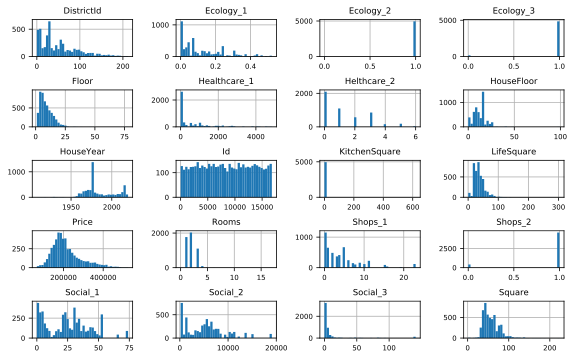

In [60]:
feats1 = list(filter(lambda s: s[0:9] != 'flat_qty_' and s[0:5] != 'mean_' and s[0:4] != 'mdn_', train.columns))
data1 = pd.DataFrame(test, columns=feats1)

data1.hist(bins=40, figsize=(8, 5), zorder=2)
plt.tight_layout()
plt.xlabel('', fontsize=4);

In [56]:
# min_year = np.int(test['HouseYear'].min())
# max_year = np.int(test['HouseYear'].max())
# display((min_year, max_year))

# for year in np.sort(test['HouseYear'].unique()):
#     if year < 1964:
#         continue
#     data_year = test[test['HouseYear'] == year]
#     data_year_2 = test[(test['HouseYear'] == year) & (data['Floor'] > data['HouseFloor'])]
#     plt.scatter(data_year[feat], data_year['Price'], zorder=2);
#     plt.scatter(data_year_2[feat], data_year_2['Price'], zorder=2);
    
#     min_hf = np.int(test[test['HouseYear'] == year][feat].min())
#     max_hf = np.int(test[test['HouseYear'] == year][feat].max() + 0.99)
    
#     plt.xticks(range(min_hf, max_hf))
#     plt.gca().xaxis.grid(True)
#     plt.gcf().set_size_inches(11, 3)
#     plt.title(year)
#     plt.show()

In [57]:
test['Price'] = model.predict(test.loc[:, feats_])

In [59]:
test.loc[:, ['Id', 'Price']].to_csv('AAnonymous_predictions.csv', index=None)